<a href="https://colab.research.google.com/github/NosenkoArtem/Categorical-Encoding/blob/master/LLMpro_hw4_NosenkoArtem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание: Сбор данных и разметка: от формулировки задачи до крауда

В этом кейсе вы пройдёте путь **от постановки бизнеса** до **пайплайна гибридной разметки**:  
Постановка задачи → разметка zero shot промптом с помощью LLM → оценка качества → Улучшение качества промпта: few-shot, cot и другие способы → Оценка уверенности ответа




### Установка зависимостей

In [1]:
import torch, json, random, re, pandas as pd, numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from sklearn.metrics import precision_recall_fscore_support
from tqdm.auto import tqdm
torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)


Device: cuda


In [ ]:
# !pip uninstall -y fsspec datasets
# !pip install fsspec==2024.2.0 datasets==2.18.0

## 1. Постановка задачи


**Контекст (от лица бизнеса):**
Наша компания разрабатывает финтех-приложение с поддержкой пользователей через чат-бот.
Мы хотим автоматически определять тему запроса клиента (например: "блокировка карты", "потеря ПИН-кода", "перевыпуск карты", и т.д.), чтобы быстро направлять клиента к нужному решению. Требуется получить данные для задачи




**Описание задачи:**
> "Для каждого входящего текстового сообщения пользователя автоматически определить одну из тематик (например, balance, card_not_working, transfer, etc.)"

## 2. Требования и бизнес-метрики – 1 балл

Предложите не менее 2 бизнес-метрик, которые может хотеть оптимизировать бизнес относительно процесса разметки данных для данной задачи.


Хорошими метриками будут метрики:

**0. Верность разметки**

0.1 Что измеряет: насколько выбранный процесс разметки верно размечает golden/калибровочный датасет.

0.2 Как считается: процент совпавшей разметки с эталонной разметкой на golden/калибровочный датасет. Такая метика оценивает уровень ошибки, который мы получилим в результате разметки.

**1. Стоимость разметки одной единицы данных**

1.1 Что измеряет: Экономическую эффективность процесса.
Показывает, сколько стоит компании (в деньгах или времени)
разметить один запрос пользователя

1.2 Как считается: `(Общие затраты на разметку) / (Количество размеченных сообщений)`.

Затраты могут включать: зарплаты асессоров/аналитиков, стоимость услуг сторонней платформы или краудсорсинга, временные затраты внутренних экспертов или затраты на LLM в случае  LLM-as-jurge


**2. Согласованность разметки**

2.1 Что измеряет: Надежность и непротиворечивость создаваемого датасета. Показывает, насколько независимые разметчики совпадают в присвоении категории одному и тому же сообщению.

2.2 Как считается: Несколько разметчиков независимо классифицируют одну и ту же выборку сообщений. Затем их ответы сравниваются с помощью выбранной статистической меры.

Низкая согласованность — прямой сигнал о проблемах, которые увеличат стоимость и снизят качество модели

**3. Скорость итерации на добавление новых тем (оценка всего процесса разметки)**

3.1 Что измеряет: Как быстро бизнес может реагировать на изменения, добавляя новые категории запросов (например, когда у нас появился новый класс).

3.2 Как считается: вемя от момента принятия решения о введении новой темы до момента, когда модель, обученная на данных, включающих эту тему, готова к развертыванию. Ключевая часть этого срока — цикл создание инструкции -> разметка -> проверка согласованности.

Важно быстро адаптировать решение под новые темы/источники, регуляторные требования или всплески определенных запросов. Оптимизированный, стандартизированный процесс разметки (что отражается в первых двух метриках) напрямую ускоряет эту метрику.

In [ ]:
# ваш ответ тут

# ---- Ваш код здесь ----
print("""
Хорошими метриками будут метрик
""")
# ---- Конец кода ----

## 3. Сведение к ML-задаче – 2 балла



Сведите бизнес-задачу к задаче машинного обучения, опишите входные данные и метки:

- **Тип задачи**: Классификация текстов (многоклассовая классификация)  с одним предсказанным классом на объект.
- **Объект**: Текстовое сообщение пользователя, отправленное в чат-бот. Можно в качестве признаков также докдывать информацию о пользователе/сессии/предыдущих сообщениях пользователя.
- **Метки**: Категория/класс запроса из фиксированного набора классов.


  Набор меток должен быть 1-исчерпывающим (покрывать большинство запросов) и 2-непересекающимся (один запрос логически относится только к одной теме). Для запросов, не подпадающих ни под одну тему, часто добавляют метку

In [ ]:
# ваш ответ тут

# ---- Ваш код здесь ----
print("""
- **Тип задачи**:
- **Объект**:
- **Метки**:
""")
# ---- Конец кода ----

## 4. ML-метрики – 2 балла


Сформулируйте, какие метрики вы будете отслеживать в процессе сбора данных и получения разметки: как при помощи LLM, так и при помощи разметчиков в крауде

LLM разметчик:

1) Precision (macro, micro)\
  Доля правильно предсказанных моделью или разметчиком меток среди всех предсказанных для данного класса
2) Recall (macro, micro)\
  Доля правильно найденных меток среди всех истинных меток этого класса в эталоне
3) F1-мера (F1-score)\
  Гармоническое среднее Precision и Recall, дает сбалансированную оценку


Человек-разметчик. К предыдущим метрикам добавляется

4) Согласованность между аннотаторами (IAA)\
  Низкий IAA сигнализирует о плохих инструкциях, неоднозначных классах или низкой квалификации разметчиков

In [ ]:
# ---- Ваш код здесь ----
print("""
- LLM разметчик: (метрики)
- Разметчики в крауде: (метрики)

""")
# ---- Конец кода ----



## 5. Данные и бейзлайн разметка

### 5.1 Загрузка и первичный анализ датасета

Посмотрим данные: примеры из датасета (попробуем разметить сами хотя бы 10 примеров), все типы меток, размеры выборок, распределение

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
# !pip uninstall -y fsspec datasets
# !pip install fsspec==2024.2.0 datasets==2.18.0

from datasets import load_dataset
import pandas as pd

ds = load_dataset('banking77')
ds.set_format('pandas')


# ---- Ваш код здесь ----
print("""
Считываем данные
""")
# ---- Конец кода ----

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/298k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/93.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]


Считываем данные



In [4]:
df_train = ds['train'][:]
df_test = ds['test'][:]

In [5]:
# сделаем маппинг описание label и самих label
label_names = ds['train'].features['label'].names
id2label = {i: label for i, label in enumerate(label_names)}

# глянем на категории
print(f"Всего категорий: {len(label_names)}")
print(f"Первые 5 категорий: {label_names[:5]}")

Всего категорий: 77
Первые 5 категорий: ['activate_my_card', 'age_limit', 'apple_pay_or_google_pay', 'atm_support', 'automatic_top_up']


In [6]:
id2label

{0: 'activate_my_card',
 1: 'age_limit',
 2: 'apple_pay_or_google_pay',
 3: 'atm_support',
 4: 'automatic_top_up',
 5: 'balance_not_updated_after_bank_transfer',
 6: 'balance_not_updated_after_cheque_or_cash_deposit',
 7: 'beneficiary_not_allowed',
 8: 'cancel_transfer',
 9: 'card_about_to_expire',
 10: 'card_acceptance',
 11: 'card_arrival',
 12: 'card_delivery_estimate',
 13: 'card_linking',
 14: 'card_not_working',
 15: 'card_payment_fee_charged',
 16: 'card_payment_not_recognised',
 17: 'card_payment_wrong_exchange_rate',
 18: 'card_swallowed',
 19: 'cash_withdrawal_charge',
 20: 'cash_withdrawal_not_recognised',
 21: 'change_pin',
 22: 'compromised_card',
 23: 'contactless_not_working',
 24: 'country_support',
 25: 'declined_card_payment',
 26: 'declined_cash_withdrawal',
 27: 'declined_transfer',
 28: 'direct_debit_payment_not_recognised',
 29: 'disposable_card_limits',
 30: 'edit_personal_details',
 31: 'exchange_charge',
 32: 'exchange_rate',
 33: 'exchange_via_app',
 34: 'extr

Text(0, 0.5, 'Название намерения (Intent)')

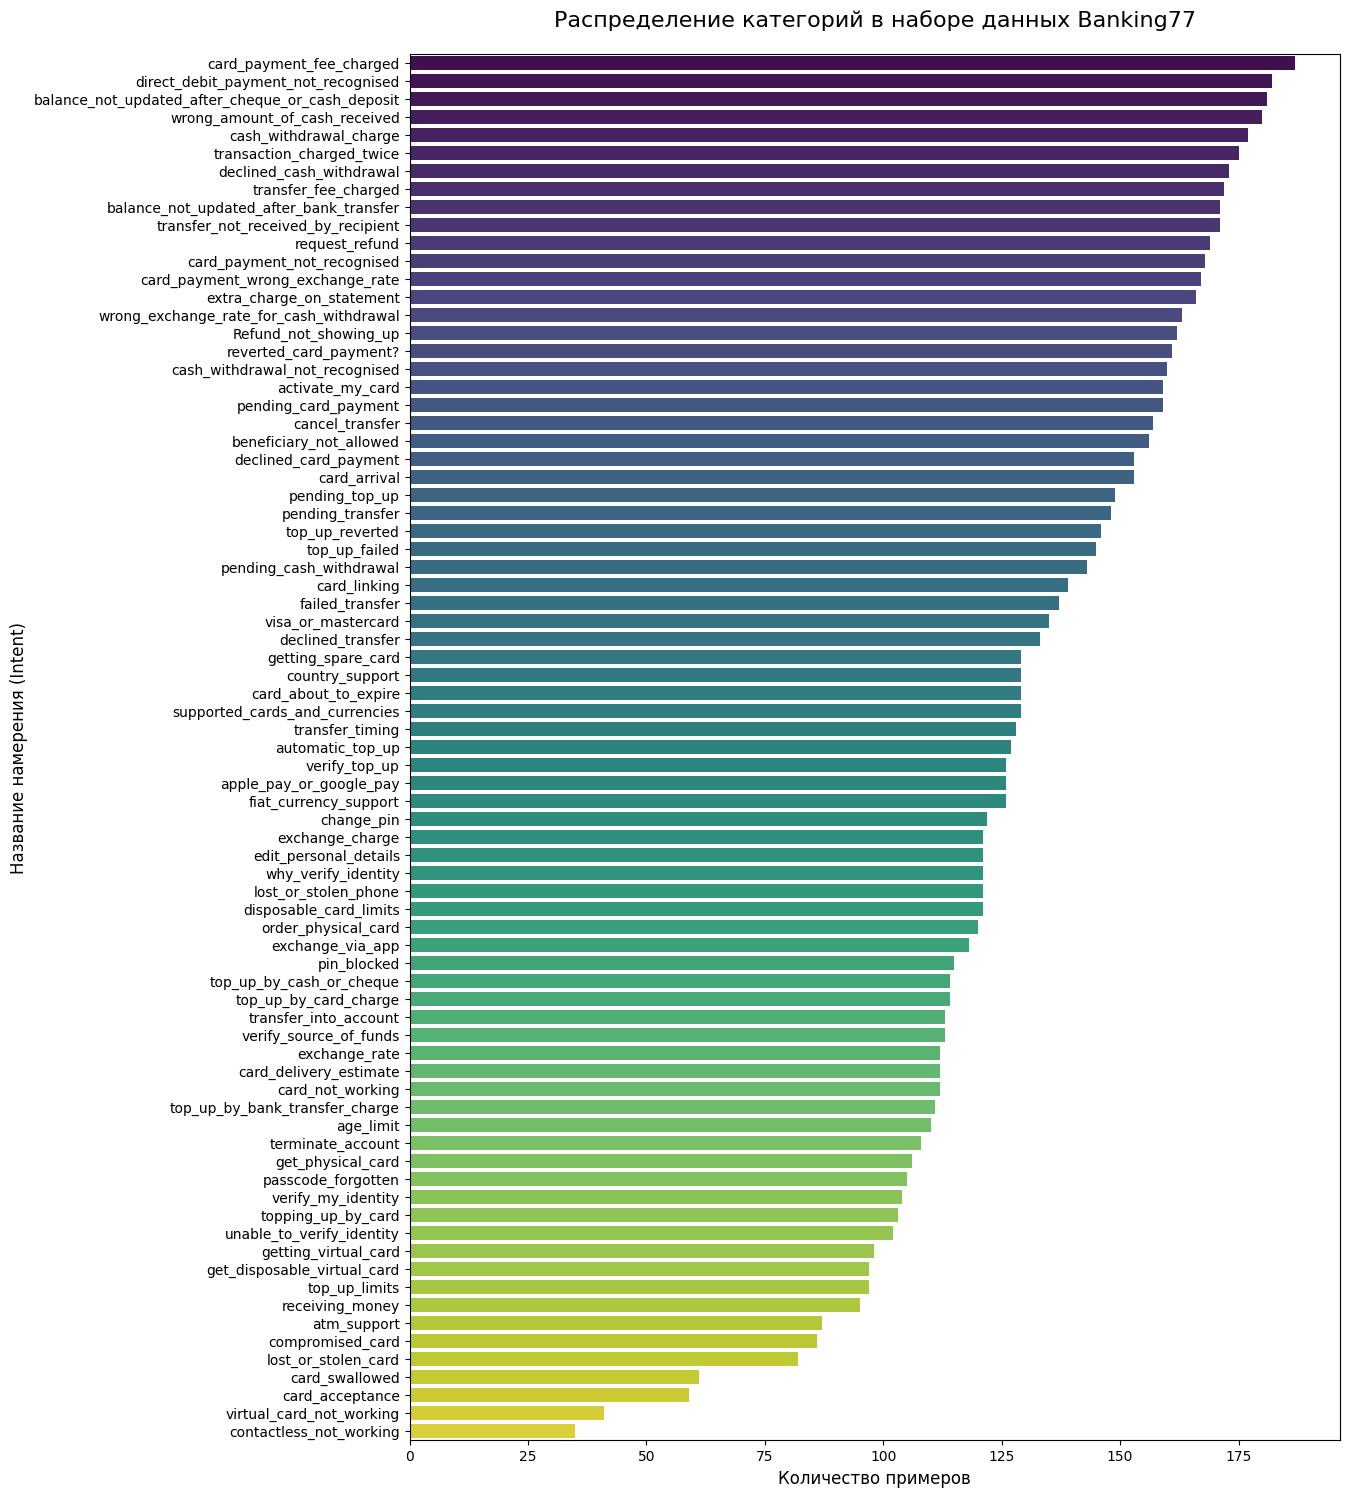

In [ ]:
tmp = df_train['label'].value_counts().reset_index()
tmp.columns = ['label_id', 'count']

tmp['label_name'] = tmp['label_id'].apply(lambda x: label_names[x])

plt.figure(figsize=(12, 18))

plot = sns.barplot(
    data=tmp,
    x='count',
    y='label_name',
    hue='label_name',  # В новых версиях seaborn это рекомендуется для управления цветом
    palette='viridis',
    legend=False
)

plt.title('Распределение категорий в наборе данных Banking77', fontsize=16, pad=20)
plt.xlabel('Количество примеров', fontsize=12)
plt.ylabel('Название намерения (Intent)', fontsize=12)

Text(0, 0.5, 'Название намерения (Intent)')

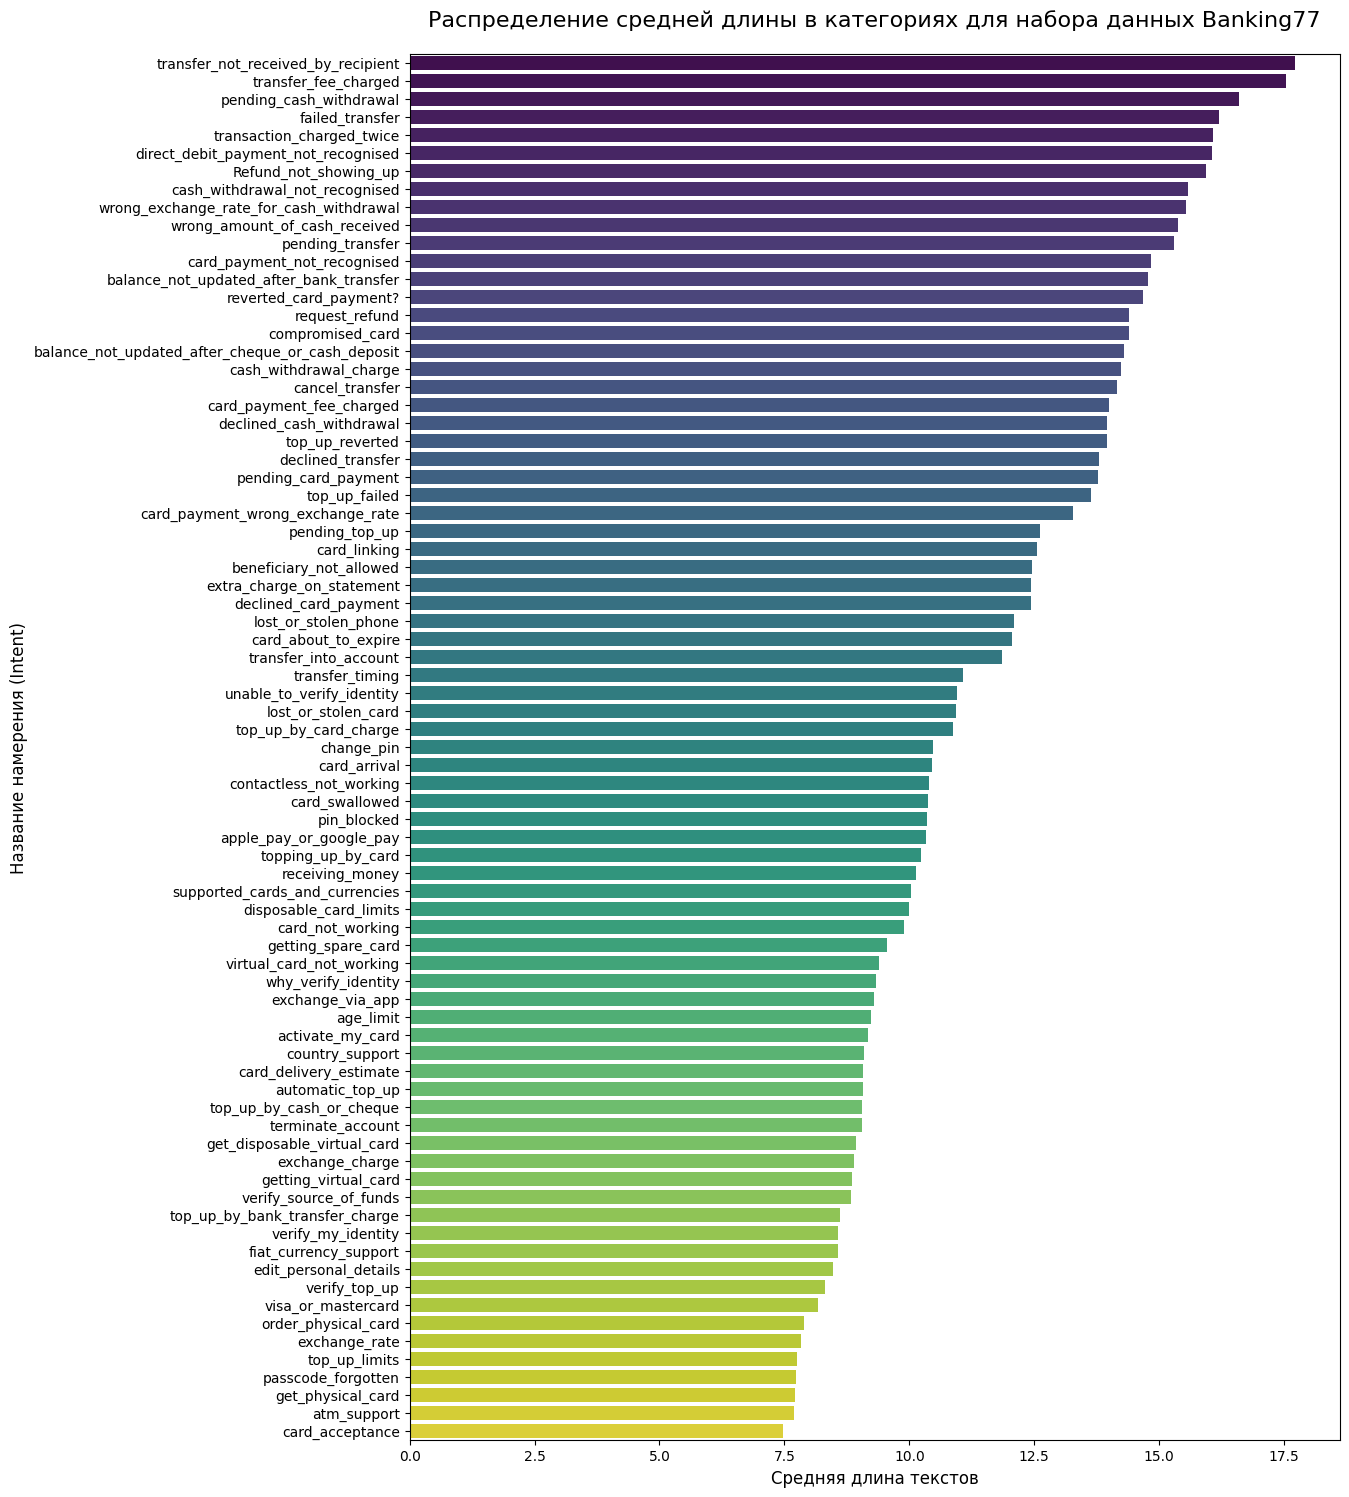

In [ ]:
tmp = df_train.copy()
tmp['len'] = tmp['text'].apply(lambda x: len(x.strip().split(' ')))
tmp['label_name'] = tmp['label'].apply(lambda x: label_names[x])
tmp = tmp.groupby('label_name')['len'].\
                          mean().reset_index().\
                          sort_values(by='len', ascending=False)

plt.figure(figsize=(12, 18))

plot = sns.barplot(
    data=tmp,
    x='len',
    y='label_name',
    hue='label_name',  # В новых версиях seaborn это рекомендуется для управления цветом
    palette='viridis',
    legend=False
)

plt.title('Распределение средней длины в категориях для набора данных Banking77', fontsize=16, pad=20)
plt.xlabel('Средняя длина текстов', fontsize=12)
plt.ylabel('Название намерения (Intent)', fontsize=12)

**Выводы:**

1) Всего 77 категорий, есть популярные категории (>175 примеров) и непопулярные категории (~30-60 примеров)

2) Классы могут немного пересекаться, так как несколько классов относятся к одному продукту и определенной проблеме (например, проблемы с доставкой: `card_arrival`, `card_delivery_estimate`)

3) Классов достаточно много: разметчику будет сложно размечать на такое количество классов

4) Сообщения достаточно короткие (в среднем 7 - 20), для некоторых классов тексты в среднем длинее (ближе к 20 слов).

### 5.2 Бейзлайн LLM разметка (7 баллов)

В этом пункте нужно получить бейзлайн разметку с помощью open source LLM и простого короткого промпта.

Для упрощения тут у нас уже есть golden set разметка (в случае если не было бы, то действовали как указано в лекции, или бы размечали для начала сами хотя бы 50-100 примеров), на которой мы можем проверять качество

В качестве LLM можно также взять https://huggingface.co/IlyaGusev/saiga_yandexgpt_8b . Либо можно заменить на любую open-source (например "Qwen/Qwen3-8B", "meta-llama/Meta-Llama-3-8B-Instruct", "mistralai/Mistral-7B-Instruct-v0.2", и т.д.)

Я попробую использовать `GigaChat-Max`

In [7]:
!pip install langchain langchain-core -qq
!pip install --upgrade langchain langchain-core langchain-community -qq
!pip install gigachat -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 3.7 MB/s eta 0:00:00


In [8]:
import langchain
from langchain_community.chat_models import GigaChat
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser

from pydantic import BaseModel
from typing import List
from pprint import pprint

import yaml

from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

In [9]:
base_system_prompt = """
Ты — экспертный аналитик данных в службе поддержки крупного международного банка.
Твоя специализация — классификация интентов (намерений) пользователей на основе коротких текстовых сообщений из чата.

### Твоя задача:
Проанализировать входящее сообщение и соотнести его строго с ОДНИМ из 77 классов.
Используй предоставленный ниже маппинг, обращая внимание на тонкие различия между похожими категориями.

### Список доступных классов (ID: Название):
{mapping}

### Формат ответа:
```json
{{"label": 32}}
```

###Правила разметки:

1) **Не добавляй** никакого дополнительного текста кроме JSON
2) **Обязательно выбери один из label от 0 до 76**

"""

human_prompt = """
Сообщение из чат-бота для разметки: {texts}
"""

In [ ]:
# pprint(system_prompt)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
class LabelResult(BaseModel):
  label : int

PATH_TO_CONFIG = '/content/drive/MyDrive/llmpro_hw1/config.yaml'

with open(PATH_TO_CONFIG, 'r') as f:
  params = yaml.load(f, Loader=yaml.SafeLoader)

prompt_template = ChatPromptTemplate.from_messages([
    ("system", base_system_prompt),
    ("human", human_prompt)
])
mapping_text = str(id2label)

parser = PydanticOutputParser(pydantic_object=LabelResult)
llm = GigaChat(**params)

chain = prompt_template | llm | parser

/tmp/ipython-input-973892264.py:16: LangChainDeprecationWarning: The class `GigaChat` was deprecated in LangChain 0.3.5 and will be removed in 1.0. An updated version of the class exists in the `langchain-gigachat package and should be used instead. To use it run `pip install -U `langchain-gigachat` and import as `from `langchain_gigachat import GigaChat``.
  llm = GigaChat(**params)


In [ ]:
sample_text = df_train.sample(50, random_state=42)

results = []
for df_i in tqdm(sample_text['text']):
  message = df_i
  results_i = chain.invoke({"mapping": mapping_text, 'texts' : message})
  results.append(results_i.model_dump()['label'])

100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


In [ ]:
sample_text['prediction'] = results

Оценим качество разметки на этом sample данных

In [13]:
def evaluate_model_metrics(y_true, y_pred):
    """
    Рассчитывает Micro и Macro F1, Precision, Recall.

    Args:
        y_true (np.array): Истинные метки.
        y_pred (np.array): Предсказанные метки.

    Returns:
        dict: Словарь с рассчитанными метриками.
    """
    metrics = {}

    # --- Micro-усреднение ---
    metrics['micro_precision'] = precision_score(y_true, y_pred, average='micro')
    metrics['micro_recall'] = recall_score(y_true, y_pred, average='micro')
    metrics['micro_f1'] = f1_score(y_true, y_pred, average='micro')

    # --- Macro-усреднение ---
    metrics['macro_precision'] = precision_score(y_true, y_pred, average='macro')
    metrics['macro_recall'] = recall_score(y_true, y_pred, average='macro')
    metrics['macro_f1'] = f1_score(y_true, y_pred, average='macro')

    # --- Weighted-усреднение (часто используется для компромисса) ---
    metrics['weighted_f1'] = f1_score(y_true, y_pred, average='weighted')

    return metrics

In [ ]:
y_true, y_pred = sample_text['label'].values, sample_text['prediction'].values
results = evaluate_model_metrics(y_true, y_pred)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print("Результаты оценки разметки:")
for key, value in results.items():
    print(f"{key:20}: {value:.4f}")

Результаты оценки модели:
micro_precision     : 0.6400
micro_recall        : 0.6400
micro_f1            : 0.6400
macro_precision     : 0.5199
macro_recall        : 0.5109
macro_f1            : 0.4998
weighted_f1         : 0.6368


In [ ]:
full_report = classification_report(y_true, y_pred, zero_division=0)
print("\n--- Полный отчет по всем 77 классам ---")
print(full_report)


--- Полный отчет по всем 77 классам ---
              precision    recall  f1-score   support

           4       1.00      0.50      0.67         2
           5       1.00      0.50      0.67         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
          11       1.00      0.50      0.67         2
          12       0.67      1.00      0.80         2
          13       1.00      1.00      1.00         1
          14       0.00      0.00      0.00         0
          15       1.00      0.50      0.67         2
          17       0.00      0.00      0.00         1
          19       1.00      1.00      1.00         1
          20       0.00      0.00      0.00         1
          21       1.00      1.00      1.00         1
          24       1.00      1.00      1.00         2
          25       0.50      0.50      0.50         2
          27       0.50      0.50      0.50         2
          28       1.00      1.00      1

In [ ]:
# !pip install -U accelerate bitsandbytes transformers

Формируем простой короткий промпт, в котором укажем  все категории меток для разметки, и потребуем выход в нужном формате json {"label": str}, для которого напишем функцию парсинга



In [ ]:
# ---- Ваш код здесь ----
prompt_template = (
    "Текст промпта для разметки"
    )
# ---- Конец кода ----


Делаем разметку 10-20 примеров, пишем функцию парсинга ответа (считаем метрику в скольких ответах нарушения следования формату), смотрим ответы

In [ ]:
# Функция разметки вместе с промптом,

# ---- Ваш код здесь ----
print("""
    прокачиваем в цикле выбранную LLM для разметки данных через функцию annotate, добавляем разметку в исходный датасет и сохраняем в файл
""")
# ---- Конец кода ----



    прокачиваем в цикле выбранную LLM для разметки данных через функцию annotate, добавляем разметку в исходный датасет и сохраняем в файл



### 5.3 Оценка качества (2 балла)

Оцениваем качество разметки на тестовом датасет (либо на семпле из тестового датасета)



In [ ]:
sample_text = df_test

results = []
for df_i in tqdm(sample_text['text']):
  message = df_i
  results_i = chain.invoke({"mapping": mapping_text, 'texts' : message})
  results.append(results_i.model_dump()['label'])

100%|██████████| 3080/3080 [23:34<00:00,  2.18it/s]


In [ ]:
sample_text['prediction'] = results

In [ ]:
y_true, y_pred = sample_text['label'].values, sample_text['prediction'].values
results = evaluate_model_metrics(y_true, y_pred)

In [ ]:
print("Результаты оценки разметки:")
for key, value in results.items():
    print(f"{key:20}: {value:.4f}")

Результаты оценки разметки:
micro_precision     : 0.7127
micro_recall        : 0.7127
micro_f1            : 0.7127
macro_precision     : 0.7361
macro_recall        : 0.7127
macro_f1            : 0.7020
weighted_f1         : 0.7020


In [ ]:
full_report = classification_report(y_true, y_pred, zero_division=0)
print("\n--- Полный отчет по всем 77 классам ---")
print(full_report)


--- Полный отчет по всем 77 классам ---
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        40
           1       0.98      1.00      0.99        40
           2       0.96      0.68      0.79        40
           3       0.90      0.88      0.89        40
           4       0.94      0.80      0.86        40
           5       0.73      0.20      0.31        40
           6       1.00      0.80      0.89        40
           7       0.32      0.33      0.32        40
           8       0.80      0.10      0.18        40
           9       0.96      0.62      0.76        40
          10       0.71      0.80      0.75        40
          11       0.46      0.33      0.38        40
          12       0.49      0.85      0.62        40
          13       0.89      0.85      0.87        40
          14       0.84      0.80      0.82        40
          15       0.96      0.57      0.72        40
          16       0.71      0.38      0

Вывод: весьма неплохо для бейзлайна

In [ ]:
# ---- Ваш код здесь ----
print("""
    Инферим LLM на тесте, замеряем метрики
""")
# ---- Конец кода ----



### 6. Улучшение качества промпта

### 6.1 few shot prompt (4 баллов)

Добавим в промпт few-shot примеры (важно, чтобы не было data leak  c тестом): помогает исправлять поведение модели, когда описание в инструкции не справляется + модель лучше следует форматам

In [35]:
system_prompt = """
Ты — экспертный аналитик данных в службе поддержки крупного международного банка.
Твоя специализация — классификация интентов (намерений) пользователей на основе коротких текстовых сообщений из чата.

### Твоя задача:
Проанализировать входящее сообщение и соотнести его строго с ОДНИМ из 77 классов.
Используй предоставленный ниже маппинг, обращая внимание на тонкие различия между похожими категориями.

### Список доступных классов (ID: Название):
{mapping}

### Формат ответа:
```json
{{"label": 32}}
```

### Правила разметки:

1) **Не добавляй** никакого дополнительного текста кроме JSON
2) **Обязательно выбери один из label от 0 до 76**

### Примеры размеченного текста:
{few_shot}

"""

human_prompt = """
Сообщение из чат-бота для разметки: {texts}
"""

In [15]:
few_shot = dict(zip(
    df_train.sample(100, random_state=43)['text'],
    df_train.sample(100, random_state=43)['label']
))

# few_shot

In [91]:
PATH_TO_CONFIG = '/content/drive/MyDrive/llmpro_hw1/config.yaml'

with open(PATH_TO_CONFIG, 'r') as f:
  params = yaml.load(f, Loader=yaml.SafeLoader)

prompt_template = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", human_prompt)
])
mapping_text = str(id2label)

parser = PydanticOutputParser(pydantic_object=LabelResult)
llm = GigaChat(**params)

chain = prompt_template | llm | parser

# базовый пайплайн
prompt_template = ChatPromptTemplate.from_messages([
    ("system", base_system_prompt),
    ("human", human_prompt)
])
mapping_text = str(id2label)

parser = PydanticOutputParser(pydantic_object=LabelResult)
llm = GigaChat(**params)

base_chain = prompt_template | llm | parser

In [66]:
sample_text = df_train.sample(50, random_state=42)

results = []
for df_i in tqdm(sample_text['text']):
  message = df_i
  results_i = chain.invoke({"mapping": mapping_text, 'texts' : message, 'few_shot' : few_shot})
  results.append(results_i.model_dump()['label'])

100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


In [67]:
sample_text['prediction'] = results
y_true, y_pred = sample_text['label'].values, sample_text['prediction'].values
results = evaluate_model_metrics(y_true, y_pred)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [68]:
print("Результаты оценки разметки:")
for key, value in results.items():
    print(f"{key:20}: {value:.4f}")

Результаты оценки разметки:
micro_precision     : 0.6800
micro_recall        : 0.6800
micro_f1            : 0.6800
macro_precision     : 0.5707
macro_recall        : 0.5435
macro_f1            : 0.5476
weighted_f1         : 0.6914


Без few-shot качество было хуже (но тут возможен leak):
Результаты оценки модели:


| Метрика         | Значение |
| :-------------- | -------: |
| micro_precision |  0.6400  |
| micro_recall    |  0.6400  |
| micro_f1        |  0.6400  |
| macro_precision |  0.5199  |
| macro_recall    |  0.5109  |
| macro_f1        |  0.4998  |
| weighted_f1     |  0.6368  |



In [16]:
from tenacity import retry, stop_after_attempt, wait_exponential

In [94]:
@retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10))
def classify_with_retry(chain, text):
  try:
    result = chain.invoke({"mapping": mapping_text, 'texts' : message, 'few_shot' : few_shot})
    return result.model_dump()

  except Exception as e:
    print(f'Не удалось разметить пример : {text}')
    result = base_chain.invoke({"mapping": mapping_text, 'texts' : message, 'few_shot' : few_shot})

    return result.model_dump()

In [96]:
# а теперь протестируем на test выборке
sample_text = df_test

results = []
for df_i in tqdm(sample_text['text']):
  message = df_i
  # results_i = chain.invoke({"mapping": mapping_text, 'texts' : message, 'few_shot' : few_shot})
  result = classify_with_retry(chain, message)
  # results.append(results_i.model_dump()['label'])
  results.append(result['label'])

 19%|█▉        | 599/3080 [03:18<12:47,  3.23it/s]

Не удалось разметить пример : Should i reinstall the payment app?


100%|██████████| 3080/3080 [16:02<00:00,  3.20it/s]


In [99]:
sample_text['prediction'] = results
y_true, y_pred = sample_text['label'].values, sample_text['prediction'].values
results_metrics = evaluate_model_metrics(y_true, y_pred)

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [100]:
print("Результаты оценки разметки:")
for key, value in results_metrics.items():
    print(f"{key:20}: {value:.4f}")

Результаты оценки разметки:
micro_precision     : 0.7818
micro_recall        : 0.7818
micro_f1            : 0.7818
macro_precision     : 0.7965
macro_recall        : 0.7818
macro_f1            : 0.7694
weighted_f1         : 0.7694


Вывод: метрики существенно подросли по сравнению с бейзлайном:


| Метрика         | Значение |
| :-------------- | -------: |
| micro_precision |  0.7127  |
| micro_recall    |  0.7127  |
| micro_f1        |  0.7127  |
| macro_precision |  0.7361  |
| macro_recall    |  0.7127  |
| macro_f1        |  0.7020  |
| weighted_f1     |  0.7020  |

### 6.2 chain-of-thoughts (3 балла)

Добавляем сhain-of-thought в промпт: требуем короткий reasoning → повышаем прозрачность решения модели (понимаем, почему размечено именно так) и улучшаем качество на более сложных задачах

Json на выходе теперь формата
{"reasoning": "why_this_class", "label": "one_of_the_categories"}

In [17]:
from tenacity import retry, stop_after_attempt, wait_exponential

In [18]:
cot_system_prompt = """
Ты — экспертный аналитик данных в службе поддержки крупного международного банка.
Твоя специализация — классификация интентов (намерений) пользователей на основе коротких текстовых сообщений из чата.

### Твоя задача:
Проанализировать входящее сообщение и соотнести его строго с ОДНИМ из 77 классов.
Используй предоставленный ниже маппинг, обращая внимание на тонкие различия между похожими категориями.

### Список доступных классов (ID: Название):
{mapping}

### Формат ответа:
```json
{{"label": 32, "reasoning" : "Выбран этот класс потому что в сообщении пишется про поломку карты"}}
```

### Правила разметки:

1) **Не добавляй** никакого дополнительного текста кроме JSON
2) **Обязательно выбери один из label от 0 до 76**
3) Прежде чем дать ответ, добавь РАССУЖДЕНИЙ для того, чтобы правильно классифицировать сообщение

### Примеры размеченного текста:
{few_shot}

"""

human_prompt = """
Сообщение из чат-бота для разметки: {texts}
"""

In [19]:
PATH_TO_CONFIG = '/content/drive/MyDrive/llmpro_hw1/config.yaml'

with open(PATH_TO_CONFIG, 'r') as f:
  params = yaml.load(f, Loader=yaml.SafeLoader)

class CoTLabelResult(BaseModel):
  label : int
  reasoning : str

prompt_template = ChatPromptTemplate.from_messages([
    ("system", cot_system_prompt),
    ("human", human_prompt)
])
mapping_text = str(id2label)

parser = PydanticOutputParser(pydantic_object=CoTLabelResult)
llm = GigaChat(**params)

chain = prompt_template | llm | parser

# базовый пайплайн
prompt_template = ChatPromptTemplate.from_messages([
    ("system", base_system_prompt),
    ("human", human_prompt)
])
mapping_text = str(id2label)

parser = PydanticOutputParser(pydantic_object=LabelResult)
llm = GigaChat(**params)

base_chain = prompt_template | llm | parser

In [28]:
@retry(stop=stop_after_attempt(20), wait=wait_exponential(multiplier=1, min=1, max=10))
def classify_with_retry(chain, message):
    few_shot = dict(zip(
                          df_train.sample(100)['text'],
                          df_train.sample(100)['label']))
    result = chain.invoke({"mapping": mapping_text, 'texts' : message, 'few_shot' : few_shot})
    return result.model_dump()

In [ ]:
# а теперь протестируем на test выборке
sample_text = df_test

results, reasoning = [], []
for df_i in tqdm(sample_text['text']):
  message = df_i
  try:
    result = classify_with_retry(chain, message)

    results.append(result.get('label', -1))
    reasoning.append(result.get('reasoning', ' '))
  except Exception as e:
    print(f"Критическая ошибка на тексте: {message[:50]}... Ошибка: {e}")
    results.append(-1)
    reasoning.append('error_after_20_retries')

  6%|▌         | 179/3080 [04:02<2:51:19,  3.54s/it]

In [ ]:
sample_text['prediction'] = results
y_true, y_pred = sample_text['label'].values, sample_text['prediction'].values
results_metrics = evaluate_model_metrics(y_true, y_pred)

In [ ]:
print("Результаты оценки разметки:")
for key, value in results_metrics.items():
    print(f"{key:20}: {value:.4f}")

### 6.3 Дальнейшие улучшения (6 баллов)

Далее улучшаем итеративно

Основные улучшения в общем случае происходит за счет:
- Аналитика ошибок,  в первую очередь анализируем ошибки разметки (только на трейне, чтобы не подогнаться под тест!), в том числе используя reasoning модели, чтобы понять причины. Также помогает спрашивать у самой модели и просить ее поправить начальный промпт/инструкцию

- Понимание бизнеса и домена, четкое описание в инструкции/промпте

Дополнительно, что тут может еще помочь:
- Упрощение задачи: размечать не одну, а несколько наиболее релеватных меток для каждого текста (=> растим recall)

- Использовать более "умные" LLM
- Размечаем с перекрытием: запускаем промпт n раз (например, 3) и агрегируем ответ. Улучшение: агрегурем результат ансамбля разных LLM (среди тех же размеров например: Qwen-3 8b) , можно с тем же промптом, либо промпты могут отлчичаться между собой few shot примерами

Тут нужно реализовать одно из улучшений (из лекции: слайды 39-41, 46, либо списка выше, например, с перекрытием). Цель - улучшить последний результат по accuracy и побить baseline: accuracy = 0.6 на тестовой выборке

Сделаем три прогона для разметки, меняя few-shot примеры

In [ ]:
@retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=4, max=10))
def classify_with_n_trial(chain, text, n_trial=3):
  labels = {}
  for i in range(n_trial):
    try:
      few_shot = dict(zip(
                          df_train.sample(100, random_state=i)['text'],
                          df_train.sample(100, random_state=i)['label']
      ))
      result = chain.invoke({"mapping": mapping_text, 'texts' : message, 'few_shot' : few_shot})
      result = result.model_dump()

    except Exception as e:
      print(f'Не удалось разметить пример : {text}')
      result = base_chain.invoke({"mapping": mapping_text, 'texts' : message, 'few_shot' : few_shot})

      result = result.model_dump()

    labels[i] = result['label']

  return labels

In [ ]:
# а теперь протестируем на test выборке
sample_text = df_test

results, reasoning = [], []
for df_i in tqdm(sample_text['text']):
  message = df_i
  # results_i = chain.invoke({"mapping": mapping_text, 'texts' : message, 'few_shot' : few_shot})
  result = classify_with_n_trial(chain, message, few_shot)
  # results.append(results_i.model_dump()['label'])
  results.append(result)

In [ ]:
# ---- Ваш код здесь ----
print("""
    Промпты с улучшением качества (baseline: accuracy = 0.6), сравнение метрик, как каждое улучшение повляило
""")
# ---- Конец кода ----


    Промпты с улучшением качества (baseline: accuracy = 0.6), сравнение метрик, как каждое улучшение повляило



## 7.1. Уверенность ответа. (11 баллов)

Посчитаем уверенность модели ответов по модели. Полезно для гибкой схемы разметки, когда более сложные примеры отправляются на разметку асессорам, либо на модель побольше, или на доп разметку с доп перекрытием.

Рабочий бейзлайн  - усредение logprob для сгенерированного текста («confidence can be approximated with the average token-level probability of the generated span»)

Здесь нужно написать функцию для взятия уверенности модели, как указано ниже, и далее показать, что числовая «уверенность» (confidence), посчитанная по лог-вероятностям токенов, действительно коррелирует с тем, ошиблась модель или нет. Ожидается получение AUC>=0.6


https://cookbook.openai.com/examples/using_logprobs


In [ ]:

# ---- Ваш код здесь ----
def annotate_conf(text: str,
                  max_new_tokens: int = 32
                 ) -> tuple[str, float, int, str]:
    """
    Размечает один запрос при помощи LLM b сразу возвращает числовую
    «уверенность» предсказания на основе лог-вероятностей сгенерированных
    токенов.

    ▸ Логика шага
      1. Формируем prompt (например с few-shot).
      2. Вызываем `model.generate(..., output_scores=True)` — получаем
         логиты (score-векторы) для каждого сгенерированного токена.
      3. Берём JSON-фрагмент ответа; если label не распарсился
         или не входит в `label_names`, ставим `corrupted = 1`.
      4. **Confidence** = `exp(mean(log p))` по токенам JSON-строки
         (кумулятивная вероятность: чем ближе к 1 — тем модель
         «увереннее» в своём выборе).

    Параметры
    ----------
    text : str
        Пользовательский запрос, который нужно классифицировать.
    max_new_tokens : int, optional
        Сколько токенов максимум разрешаем модели сгенерировать
        (включая JSON и возможный «хвост»).  Дефолт — 32.

    Возвращает
    ----------
    label : str
        Предсказанная категория (`label_names` или "other").
    confidence : float
        Уверенность модели (0 – 1).  Расчёт: exp(среднего log p токенов JSON).
    corrupted : int
        0 — JSON корректный и label ∈ `label_names`;
        1 — формат сломан **или** label не из списка.
    raw_generation : str
        Полный ответ LLM (полезно для дебага/визуализации).
    """
    return
# ---- Конец кода ----



In [ ]:
# ---- Ваш код здесь ----
print("""
1. Посчитайте roc_auc_score(y_true_bin, y_score), где
y_true_bin = 1, если модель угадала (`pred_label == true_label`)), иначе 0, y_score = confidence, который вернула annotate_conf
2. Сделайте выводы по полезности confidence
""")
# ---- Конец кода ----


## 8.1. Human-in-the-loop с шумным разметчиком

В реальных задачах разметку часто делают не идеальные эксперты, а обычные асессоры — они тоже ошибаются. Для достижения хорошего качества с ними используется разметка с перкрытием по N accесорам, а затем агрегируется разметка (например majority vote). Таким образом получаем **gold-метку** и меру "уверенности" ассесоров - насколько они сходятся в решении (например 0.75 - из 4 ассессоров 3 выбрали итоговую метку).

Часть разметки можно переложить на LLM, если уметь оценивать его уверенность.

В этом задании мы смоделируем простую схему:

- есть **gold-метка** `true_label` (используем только для оценки качества),
- есть один **"человек"-разметчик** с ошибками (`human_label`),
- есть предсказания LLM: `pred_label` и `confidence`.

Мы хотим построить **гибридную систему**:

- по умолчанию используем метку человека (`human_label`);
- если `confidence >= threshold` — считаем, что LLM очень уверен и берём его метку (`pred_label`).

### 8.2.1. Симуляция "шумного" разметчика (3 балла)

Реализуйте функцию, которая по gold-меткам `true_labels` возвращает `human_labels`:

- с вероятностью `1 - error_rate` берётся правильная метка,
- с вероятностью `error_rate` — случайная *другая* метка из `label_names`  
  (можно взять, например, `error_rate = 0.25`).

1. Реализуйте функцию `simulate_noisy_human(true_labels, label_names, error_rate=0.25, random_state=42)`.
2. Посчитайте accuracy такого разметчика относительно `true_labels`.

Замечание: в реальных задачах расхождения между разметчиками и ошибочно проставленные метки зачастую не случайны. В данном задании симулируем шум для упрощения.

In [ ]:
# ---- Ваш код здесь ----

# ---- Конец кода ----


### 8.2.2. Гибридная схема разметки (4 балла)

Реализуйте функцию, которая комбинирует разметку человека и LLM по порогу уверенности:

- по умолчанию использует `human_labels`,
- если `confidence[i] >= threshold` — вместо метки человека берёт `pred_labels[i]`,
- возвращает:
  - `overall_acc` — итоговую accuracy гибридной разметки (относительно `true_labels`),
  - `coverage` — долю объектов, где использовали LLM (от 0 до 1).

1. Реализуйте функцию  
   `simulate_hybrid(pred_labels, human_labels, true_labels, confidence, threshold)`.
2. Проверьте её на небольшом игрушечном примере

In [ ]:
# ---- Ваш код здесь ----

# ---- Конец кода ----


### 8.2.3. Подбор порога и анализ trade-off (3 балла)

1. Для `threshold` из диапазона `[0.0, 1.0]` с шагом 0.05:
   - посчитайте `overall_acc` и `coverage`;
   - выведите таблицу с колонками `threshold`, `accuracy`, `coverage`  
     (по желанию можно дополнительно построить график `accuracy` vs `coverage`).
2. Найдите значение `threshold`, при котором:
   - качество гибридной разметки **не ниже** заданного уровня (например, accuracy ≥ 0.8 *относительно gold*),
   - а `coverage` максимально возможен.

In [ ]:
# ---- Ваш код здесь ----

# ---- Конец кода ----


#### 8.2.4. Сравнение схем разметки (2 балла)

1. Посчитайте и сравните:
   - accuracy только человека (`human_labels`),
   - accuracy только LLM (`pred_labels`),
   - лучшую точку гибрида.
2. Кратко (2–3 предложения) ответьте:
   - в чём преимущество гибридного подхода по сравнению с «чисто человек» и «чисто LLM»?
   - в каких кейсах такая схема human-in-the-loop может быть особенно полезна?


In [ ]:
# ---- Ваш код здесь ----

# ---- Конец кода ----


## Итоги домашки

В этой работе мы посмотрели на разметку как на систему, где есть и люди, и LLM.

Главное, что нужно вынести:
- LLM можно использовать как разметчика (при этом важно следить за качеством ), можно улучшать промт за счет различных прдеставленных способов.
- Оценка **уверенности** по logprobs позволяет решать, где доверять модели, а где подключать человека.
- Гибридная схема human-in-the-loop часто лучше, чем «только крауд» или «только LLM»: мы разгружаем людей на простых примерах и сохраняем качество на сложных.
- Эти идеи масштабируются дальше: улучшение промптов, дообучение модели, active learning и более умные пайплайны разметки.
